# This model is being trained with [Customer Support on Twitter](https://www.kaggle.com/thoughtvector/customer-support-on-twitter) dataset.

This Kaggle dataset includes more than 3 million tweets and responses from leading brands on Twitter.

In [1]:
%%bash
python -m spacy download en
# python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


### Data Download and Preparation

In [ ]:
# download from kaggle
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
import os

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 1.5MB 8.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 4.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=eb9481277f1f740c592b14f1e3667fec64f409a07debef78a23a4227b38fc57f
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make su

## Data Download and Preparation

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import string

In [ ]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="anyltcamitk"
os.environ['KAGGLE_KEY']="fc7e68b47141c6fe0abcbd70b0a256e8"

In [ ]:
# !kaggle datasets download twcs
!kaggle datasets download thoughtvector/customer-support-on-twitter
!unzip -q -o customer-support-on-twitter.zip -d customer-support-on-twitter
TWEET_FILE_FOLDER = "/content/customer-support-on-twitter/twcs/twcs.csv"

 98% 166M/169M [00:03<00:00, 46.9MB/s]
100% 169M/169M [00:03<00:00, 51.0MB/s]


In [ ]:
## Lets understand the data a bit first
tweets = pd.read_csv(TWEET_FILE_FOLDER)
tweets.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [ ]:
tweets.shape # No of rows 2811774 and 7 column

(2811774, 7)

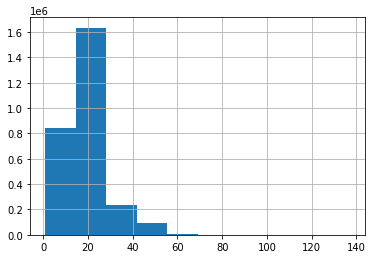

In [ ]:
#Distribution of word count for the tweets
# Let us take a look at distribution of words in each tweet
tweets.text.str.split().\
    map(lambda x: len(x)).\
    hist()

# We can see here that most of the tweets contain 5 to 25 words while there are a few tweets having a word count aobve 45.

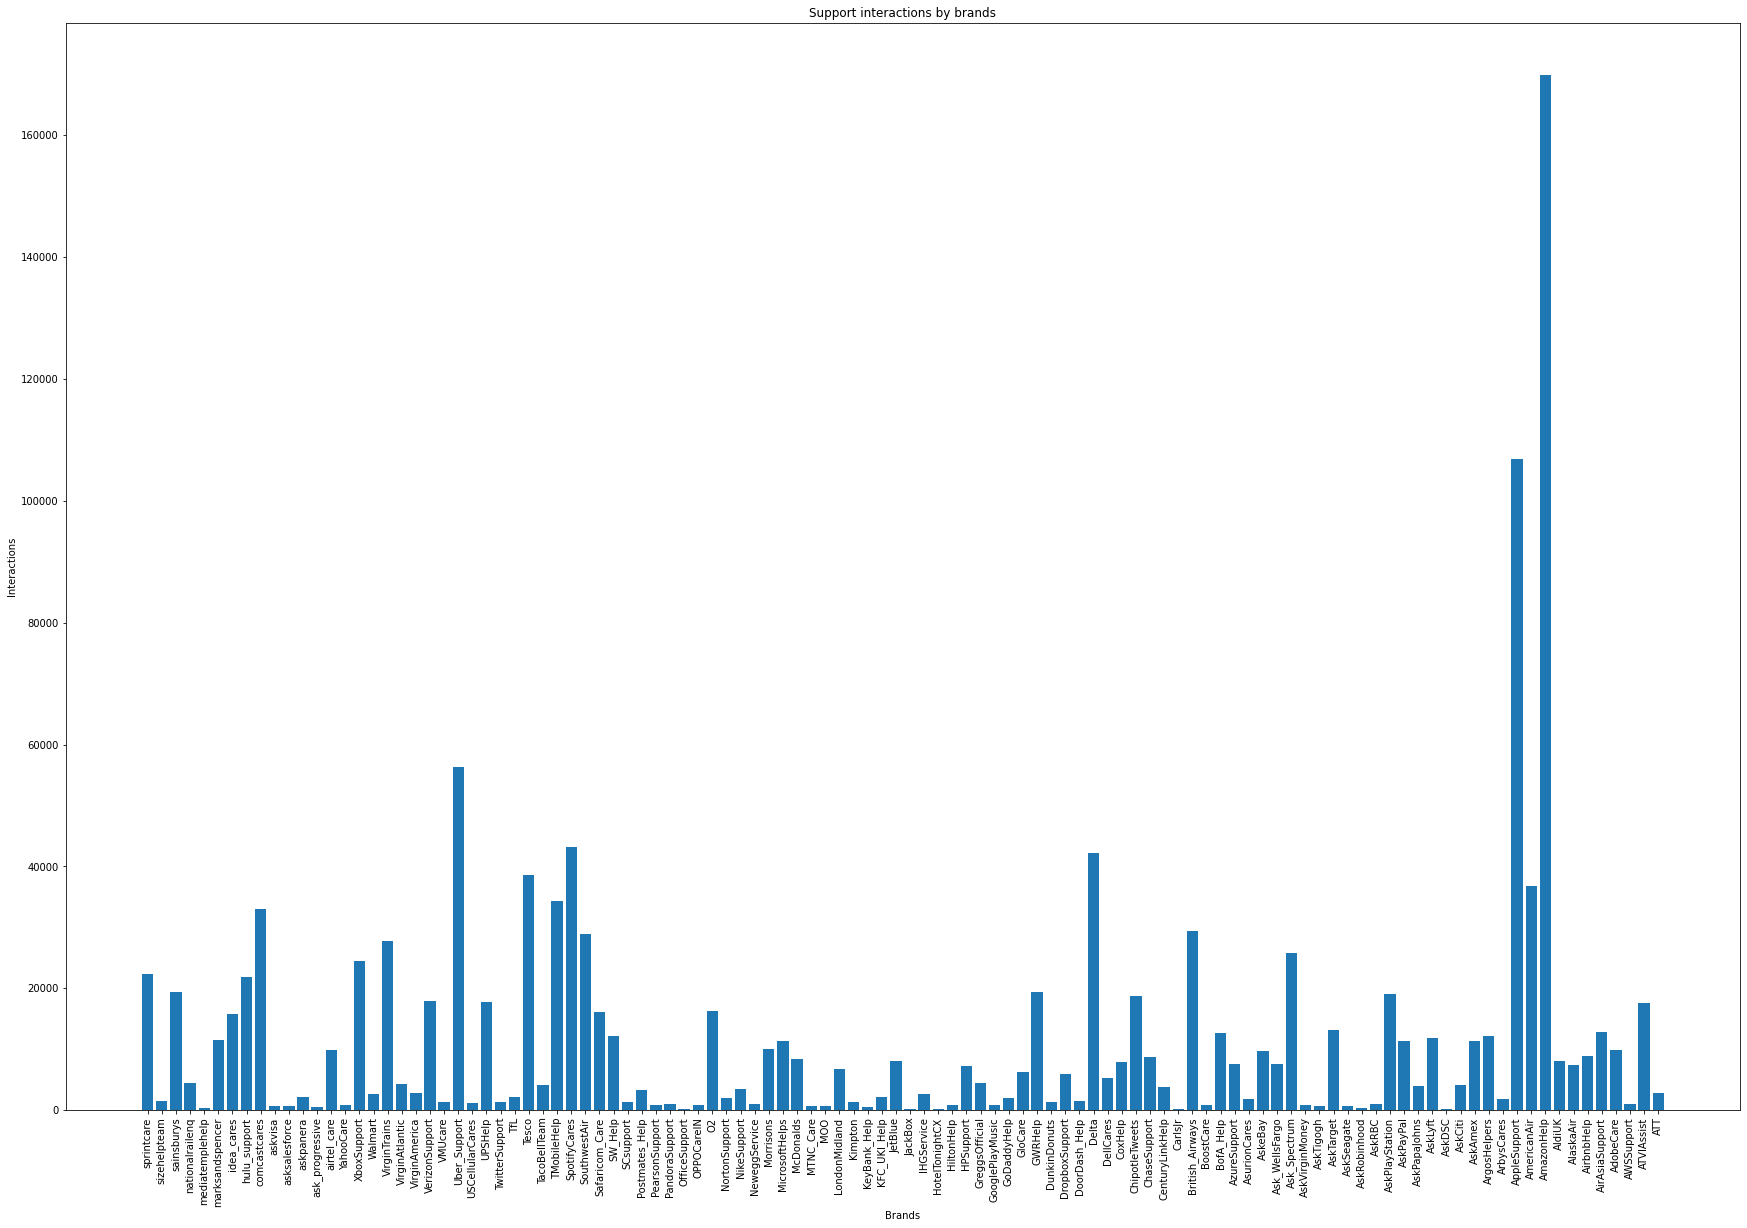

In [ ]:
support_services = tweets['author_id'].value_counts()
support_services.sort_index(ascending=False,inplace=True)
support_services = support_services[:108]


%matplotlib inline

plt.figure(figsize=(30,20))
plt.title('Support interactions by brands')
plt.xlabel('Brands')
plt.ylabel('Interactions')
plt.bar(list(support_services.index.values),list(support_services.values))
plt.xticks(rotation=90)
plt.show()

In [ ]:
days = tweets['created_at'].str.extractall(r'(^\w+)').values

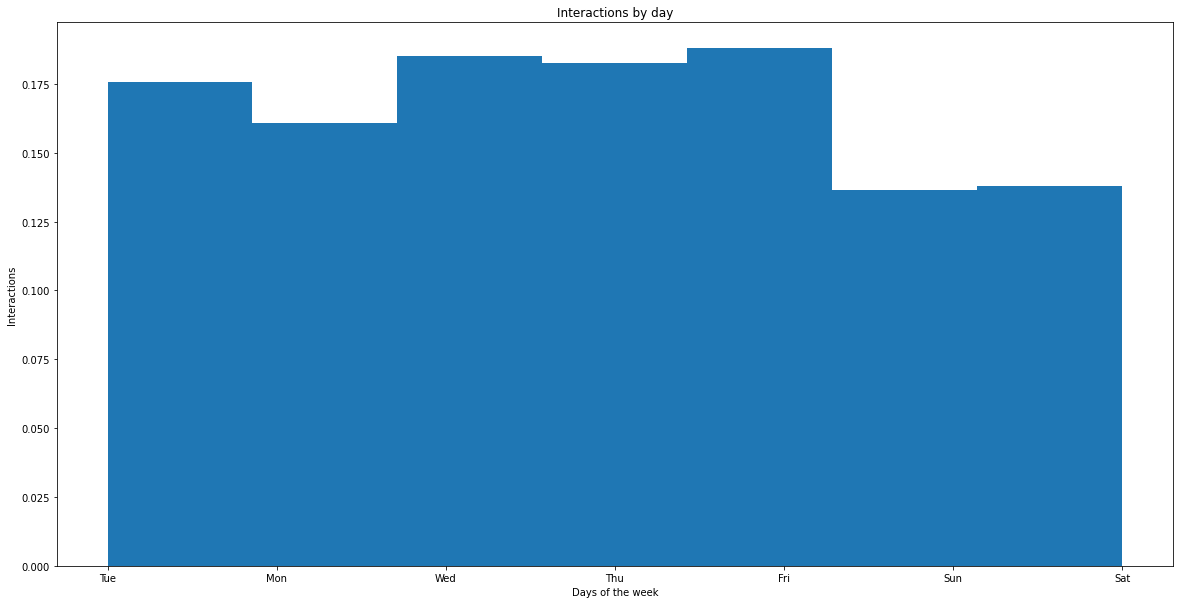

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.title('Interactions by day')
plt.xlabel('Days of the week')
plt.ylabel('Interactions')
plt.hist(days,bins=7,histtype='stepfilled',density=True)
plt.show()
# The most busy days are Tuesday and Wednesday, as you could see. 

### Data Preparation

In [ ]:
# Pick only inbound tweets that aren't in reply to anything...
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]
print('Found {} first inbound messages.'.format(len(first_inbound)))

In [ ]:
# Merge in all tweets in response
inbounds_and_outbounds = pd.merge(first_inbound, tweets, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')
print("Found {} responses.".format(len(inbounds_and_outbounds)))

In [ ]:
inbounds_and_outbounds.head(2)

In [ ]:
# Filter out cases where reply tweet isn't from company
inbounds_and_outbounds_tweets = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]


print("Found {} responses from companies.".format(len(inbounds_and_outbounds_tweets)))
# print("Tweets Preview:")
inbounds_and_outbounds_tweets.head(1)

In [ ]:
print(f'Data shape: {inbounds_and_outbounds_tweets.shape}')

In [ ]:
import re
import random
import time
# Replace anonymized screen names with common token @__sn__
def sn_replace(match):
    _sn = match.group(2).lower()
    if not _sn.isnumeric():
        # This is a company screen name
        return match.group(1) + match.group(2)
    return '@__sn__'

sn_re = re.compile('(\W@|^@)([a-zA-Z0-9_]+)')

In [ ]:
tqdm().pandas()  # Enable tracking of progress in dataframe `apply` calls

In [ ]:
print("Replacing anonymized screen names in X...")
x_text = inbounds_and_outbounds_tweets.text_x.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))
print("Replacing anonymized screen names in Y...")
y_text = inbounds_and_outbounds_tweets.text_y.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))

In [ ]:
inbounds_and_outbounds_tweets.head(2)
inbounds_and_outbounds_tweets_data = inbounds_and_outbounds_tweets[['text_x','text_y']]

In [ ]:
tweet_x = pd.DataFrame(x_text)
tweet_y = pd.DataFrame(y_text)

In [ ]:
frames = [tweet_x, tweet_y]
tweet_df =  pd.concat(frames, axis=1, sort=False)
tweet_df.reset_index(drop=True, inplace=True)

In [ ]:
tweet_df.to_csv("Tweet.csv",index=False)

In [ ]:
inbounds_and_outbounds_tweets = inbounds_and_outbounds_tweets[['text_x','text_y']]
from sklearn.model_selection import train_test_split

train, valid = train_test_split(inbounds_and_outbounds_tweets, test_size=0.2)
print(f'Training data of shape {train.shape} and test data of shape {valid.shape}.')

In [ ]:
train = train.reset_index(drop=True) ## This is being done because data.Example.fromlist was failing
valid = valid.reset_index(drop=True) ## This is being done because data.Example.fromlist was failing

In [ ]:
train.to_csv("Tweet_train.csv",index=False)
valid.to_csv("Tweet_valid.csv",index=False)

In [2]:
import random
import torch, torchtext
from torchtext import data 

### Utility Functions

**Random Deletion**

In [ ]:
# randomly delete words from a sentence with a given probability

def random_deletion(sentence, p=0.5): 
    # return if single word
    if len(sentence) == 1: 
        return sentence
    # delete words
    remaining = list(filter(lambda x: random.uniform(0,1) > p, sentence)) 
    # if nothing left, sample a random word
    if len(remaining) == 0: 
        return [random.choice(sentence)] 
    else:
        return remaining

**Random Swap**

In [ ]:
# randomly swap a pair of words in a sentence for a given # of times

def random_swap(sentence, n=5): 
    if len(sentence) < 2:
      return sentence
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

**Back Translation**

In [ ]:
# translate a sentence to a random language,
# and translate back to original language

def back_translate(sentence, p=0.1):
  # do nothing with probability of 1-p
  if random.uniform(0,1) > p:
    return sentence

  # combine tokenized sentence into one string
  sentence = ' '.join(sentence)

  # instantiate translator
  translator = google_translator()

  # choose a target language
  available_langs = list(google_trans_new.LANGUAGES.keys()) 
  trans_lang = random.choice(available_langs) 
  #print(f"Translating to {google_trans_new.LANGUAGES[trans_lang]}")

  # translate to the target language
  translations = translator.translate(sentence, lang_tgt=trans_lang) 
  #print(translations)

  # translate back to original language
  translations_en_random = translator.translate(translations, lang_src=trans_lang, lang_tgt='en') 
  #print(translations_en_random)

  # select only one translation
  if len(translations_en_random) > 1:
    translations_en_random = translations_en_random[0]

  return word_tokenize(translations_en_random)

**Carry Out Data Augmentation**

In [ ]:
for example in train.examples: 
  example.tweets = back_translate(example.tweets, p=0.01)
  example.tweets = random_deletion(example.tweets, p=0.1)
  example.tweets = random_swap(example.tweets, n=1)

### Tabular File Reading

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
# from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext import data
from torchtext import datasets

import spacy
import numpy as np

import random
import math
import time
import torch
from torchtext import data
from torchtext import datasets
import pandas as pd

In [3]:
directory = 'data'
if not os.path.exists(directory):
    os.makedirs('data')
    print("Directory '% s' created" % directory)


Directory 'data' created


In [13]:
!cp '/content/gdrive/My Drive/NLP/Tweet_train.csv' '/content/data/Tweet_train.csv'
!cp '/content/gdrive/My Drive/NLP/Tweet_valid.csv' '/content/data/Tweet_valid.csv'

In [14]:
## Now lets check how many null we have in training data
tweet_train = pd.read_csv("/content/data/Tweet_train.csv")
null_columns_tweet_train = tweet_train.columns[tweet_train.isnull().any()]
tweet_train[null_columns_tweet_train].isnull().sum()

text_y    141
dtype: int64

In [15]:
## delete null rows and overwrite old file.
tweet_train = tweet_train.dropna(how='any',axis=0) 
tweet_train.to_csv("/content/data/Tweet_train_nl.csv",index=False)

In [16]:
## Now lets check how many null we have in training data
# tweet_train = pd.read_csv("/content/data/Tweet_train_nl.csv")
null_columns_tweet_train = tweet_train.columns[tweet_train.isnull().any()]
tweet_train[null_columns_tweet_train].isnull().sum()

Series([], dtype: float64)

In [17]:
## Check for null in valid data
tweet_valid = pd.read_csv("/content/data/Tweet_valid.csv")
null_columns_tweet_valid = tweet_valid.columns[tweet_valid.isnull().any()]
tweet_valid[null_columns_tweet_valid].isnull().sum()

text_x     8
text_y    51
dtype: int64

In [18]:
## delete null rows and overwrite old file.
tweet_valid = tweet_valid.dropna(how='any',axis=0) 
tweet_valid.to_csv("/content/data/Tweet_valid_nl.csv",index=False)

In [10]:
tweet_valid.head(1)
tweet_valid.shape ## Our validation dataset has 1,58.860 no of record which is quite big to handle here in colab

(158860, 2)

In [81]:
# Count the lines
# Our validation dataset has 6,35,439 no of record which is quite big to handle here in colab
num_lines = sum(1 for l in open('/content/data/Tweet_valid_nl.csv'))
# Sample size - in this case ~10%
size = int(num_lines / 100)
# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx = random.sample(range(1, num_lines), num_lines - size)
# Read the data
data = pd.read_csv("/content/data/Tweet_valid_nl.csv", skiprows=skip_idx)
data.to_csv("/content/data/Tweet_valid_nl_fn.csv",index=False)

In [82]:
# Count the lines
# Our training dataset has 13,35,439 no of record which is quite big to handle here in colab
num_lines = sum(1 for l in open('/content/data/Tweet_train_nl.csv'))
# Sample size - in this case ~10%
size = int(num_lines / 100)
# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx = random.sample(range(1, num_lines), num_lines - size)
# Read the data
data = pd.read_csv("/content/data/Tweet_train_nl.csv", skiprows=skip_idx)
data.to_csv("/content/data/Tweet_train_nl_fn.csv",index=False)

In [83]:
from torchtext.data import Field, BucketIterator
from torchtext import data
from torchtext import datasets

In [74]:
# !shuf -n 63543 /content/data/Tweet_valid_nl.csv > /content/data/Tweet_Train_reduced.csv
# !{ echo 'text_x, text_y'; cat /content/data/Tweet_Train_reduced.csv; } > /content/data/Tweet_Train_reduced_fn.csv

In [85]:
# create Field objects
TWEET = data.Field(
    # sequential = True,
    tokenize = 'spacy', 
    # batch_first =True,
    #  use_vocab=True,
    lower = True,
    init_token = '<sos>', 
    eos_token = '<eos>', 
    #  include_lengths=True
    )

RESPONSE = data.Field(tokenize ='spacy',
                      # sequential = True, 
                      # include_lengths=True,
                      lower = True,
                      # is_target=True,
                      init_token = '<sos>', 
                      eos_token = '<eos>', 
                      # batch_first =True
                      )

fields = [('text_x', TWEET), ('text_y', RESPONSE)]

In [86]:
# load the dataset in json format
train_ds, valid_ds = data.TabularDataset.splits(
   path = 'data',
   train = 'Tweet_train_nl_fn.csv',
   validation = 'Tweet_valid_nl_fn.csv',
   format = 'csv',
   fields = fields,
   skip_header = True
)

# check an example
print(vars(train_ds[0]))

{'text_x': ['@115850', 'do', 'you', 'deliver', 'in', 'uae', '?', 'thanks'], 'text_y': ['@487143', 'i', "'m", 'sorry', 'but', 'we', 'currently', 'do', 'not', 'ship', 'to', 'international', 'locations', '.', '^ap']}


In [27]:
train_ds[0].__dict__.keys()

dict_keys(['text_x', 'text_y'])

In [28]:
## we get an Example object. The Example object bundles the attributes of a single data point together. 
# We also see that the text has already been tokenized for us, but has not yet been converted to integers
vars(train_ds.examples[10])

{'text_x': ['@hpsupport',
  '[',
  'ask',
  'your',
  'question',
  'here',
  ']',
  '#',
  'hpcpaus',
  '   ',
  'hi',
  'for',
  'some',
  'reason',
  'i',
  'have',
  'lost',
  'my',
  'movie',
  'apps',
  'and',
  'when',
  'i',
  'go',
  'to',
  'download',
  'them',
  'again',
  'it',
  'says',
  'oops',
  'error',
  'must',
  "n't",
  'be',
  'available',
  'on',
  'here',
  'anymore',
  'its',
  'happened',
  'to',
  'every',
  'computer',
  'in',
  'my',
  'house'],
 'text_y': ['@679282',
  'hey',
  'sharon',
  ',',
  'i',
  "'m",
  'here',
  'to',
  'help',
  '!',
  ' ',
  'which',
  'movie',
  'apps',
  'are',
  'you',
  'looking',
  'for',
  '?',
  'from',
  'where',
  'you',
  'are',
  'you',
  'trying',
  'to',
  'download',
  'it',
  '?',
  '...',
  '1/2']}

In [30]:
try:
    print(len(train_ds[10]))
except:
    print(train_ds[10].text_x)

['@hpsupport', '[', 'ask', 'your', 'question', 'here', ']', '#', 'hpcpaus', '   ', 'hi', 'for', 'some', 'reason', 'i', 'have', 'lost', 'my', 'movie', 'apps', 'and', 'when', 'i', 'go', 'to', 'download', 'them', 'again', 'it', 'says', 'oops', 'error', 'must', "n't", 'be', 'available', 'on', 'here', 'anymore', 'its', 'happened', 'to', 'every', 'computer', 'in', 'my', 'house']


In [87]:
# Before creating iterators of the Datasets we need to build the vocabulary for each Field object:
# This makes torchtext go through all the elements in the training set, check the contents corresponding to the TEXT field, 
# and register the words in its vocabulary. Torchtext has its own class called Vocab for handling the vocabulary. 
# The Vocab class holds a mapping from word to id in its stoi attribute and a reverse mapping in its itos attribute
TWEET.build_vocab(train_ds,
                  # max_size=20000,
                  min_freq=7)
RESPONSE.build_vocab(train_ds,
                    #  max_size=20000,
                     min_freq=7
                     )

In [88]:
print(f"Unique tokens in source (TWITTER) vocabulary: {len(TWEET.vocab)}")
print(f"Unique tokens in target (RESPONSE) vocabulary: {len(RESPONSE.vocab)}")

Unique tokens in source (TWITTER) vocabulary: 2056
Unique tokens in target (RESPONSE) vocabulary: 1444


**Restart Notebook**

# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). This model achives our best perplexity yet, ~27 compared to ~34 for the previous model.

## Introduction

As a reminder, here is the general encoder-decoder model:

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq1.png?raw=1)

In the previous model, our architecture was set-up in a way to reduce "information compression" by explicitly passing the context vector, $z$, to the decoder at every time-step and by passing both the context vector and embedded input word, $d(y_t)$, along with the hidden state, $s_t$, to the linear layer, $f$, to make a prediction.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

Even though we have reduced some of this compression, our context vector still needs to contain all of the information about the source sentence. The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? It uses *attention*. 

Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. 

$$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the session.

## Preparing Data

Again, the preparation is similar to last time.

First we import all the required modules.

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

Set the random seeds for reproducability.

In [90]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Load the German and English spaCy models.

In [91]:
# spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

We create the tokenizers.

## Build the vocabulary

Next, we'll build the vocabulary for the source and target languages. The vocabulary is used to associate each unique token with an index (an integer). The vocabularies of the source and target languages are distinct.

Using the min_freq argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an <unk> (unknown) token.

It is important to note that our vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into our model, giving us artifically inflated validation/test scores.

In [92]:
# Sentence.build_vocab(train, min_freq = 2)
# Response.build_vocab(train, min_freq = 2)

Define the device.

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [94]:
print(f"Unique tokens in source vocabulary: {len(TWEET.vocab)}")
print(f"Unique tokens in target vocabulary: {len(RESPONSE.vocab)}")

Unique tokens in source vocabulary: 2056
Unique tokens in target vocabulary: 1444


In [95]:
RESPONSE.vocab

Create the iterators.

In [96]:
BATCH_SIZE = 64
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, valid_ds),
    # sort_key=lambda x: len(x.text_x), # the BucketIterator needs to be told what function it should use to group the data.
    # sort_within_batch=True,
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.text_x),
    sort = True,
    # repeat=False, # we pass repeat=False because we want to wrap this Iterator layer
    device = device)
# https://torchtext.readthedocs.io/en/latest/examples.html

In [97]:
 b = next(iter(train_iterator)); vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text_x', 'text_y'])

In [98]:
train_ds.fields

{'text_x': <torchtext.data.field.Field at 0x7f5128772c88>,
 'text_y': <torchtext.data.field.Field at 0x7f5128bce3c8>}

In [99]:
type(train_iterator)
type(train_ds)

torchtext.data.dataset.TabularDataset

## Building the Seq2Seq Model

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq8.png?raw=1)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [100]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of $v$ as the weights for a weighted sum of the energy across all encoder hidden states. These weights tell us how much we should attend to each token in the source sequence. The parameters of $v$ are initialized randomly, but learned with the rest of the model via backpropagation. Note how $v$ is not dependent on time, and the same $v$ is used for each time-step of the decoding. We implement $v$ as a linear layer without a bias.

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq9.png?raw=1)

In [101]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq10.png?raw=1)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [102]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [103]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        # print(f"Type: {type(src)}, src:{src}")
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this session is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [104]:
INPUT_DIM = len(TWEET.vocab)
OUTPUT_DIM = len(RESPONSE.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [105]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2056, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(1444, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=1444, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [106]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,918,372 trainable parameters


We create an optimizer.

In [107]:
optimizer = optim.Adam(model.parameters())

We initialize the loss function.

In [108]:
TRG_PAD_IDX = RESPONSE.vocab.stoi[TWEET.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [109]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        # print(vars(batch))
        
        src = batch.text_x ## CHANGED here from src = batch.text_x
        # print(f"SRC:{type(src)}")
        trg = batch.text_y
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [110]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.text_x
            trg = batch.text_y

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [111]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [112]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 28s
	Train Loss: 5.153 | Train PPL: 172.951
	 Val. Loss: 4.947 |  Val. PPL: 140.783
Epoch: 02 | Time: 0m 28s
	Train Loss: 4.545 | Train PPL:  94.135
	 Val. Loss: 5.003 |  Val. PPL: 148.817
Epoch: 03 | Time: 0m 27s
	Train Loss: 4.278 | Train PPL:  72.112
	 Val. Loss: 5.051 |  Val. PPL: 156.123
Epoch: 04 | Time: 0m 28s
	Train Loss: 4.128 | Train PPL:  62.042
	 Val. Loss: 5.096 |  Val. PPL: 163.309
Epoch: 05 | Time: 0m 28s
	Train Loss: 4.005 | Train PPL:  54.865
	 Val. Loss: 5.107 |  Val. PPL: 165.256
Epoch: 06 | Time: 0m 28s
	Train Loss: 3.895 | Train PPL:  49.179
	 Val. Loss: 5.243 |  Val. PPL: 189.152
Epoch: 07 | Time: 0m 28s
	Train Loss: 3.803 | Train PPL:  44.817
	 Val. Loss: 5.199 |  Val. PPL: 181.139
Epoch: 08 | Time: 0m 28s
	Train Loss: 3.694 | Train PPL:  40.206
	 Val. Loss: 5.176 |  Val. PPL: 177.026
Epoch: 09 | Time: 0m 28s
	Train Loss: 3.591 | Train PPL:  36.265
	 Val. Loss: 5.236 |  Val. PPL: 187.935
Epoch: 10 | Time: 0m 28s
	Train Loss: 3.466 | Train PPL

Finally, we test the model on the test set using these "best" parameters.

In [113]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, valid_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.947 | Test PPL: 140.783 |
